<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.pipeline import Pipeline
CV=3
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
data.sample()

,text,toxic
96243,", which has an August 15, 2006, updated date",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
(data['toxic'].value_counts()/data['toxic'].shape).round(2)

0    0.9
1    0.1
Name: toxic, dtype: float64

In [ ]:
tqdm.pandas()
def clear_text(text):
    clean = nlp(" ".join(re.sub(r'[^a-zA-Z]', ' ', text).lower().split()))
    lemm_text = " ".join([w.lemma_ for w in clean])
    return lemm_text


data['lemmatized'] = data['text'].progress_apply(clear_text)

100%|██████████| 159292/159292 [46:21<00:00, 57.27it/s] 


In [ ]:
data.head(10)

,text,toxic,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation from I as well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


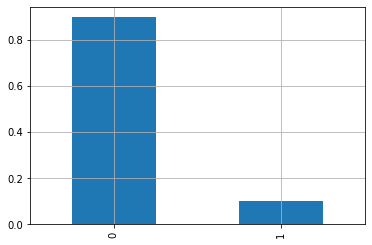

In [ ]:
toxic_comment = data['toxic'].value_counts(normalize=(0,1))
toxic_comment.plot(kind = 'bar', grid = True)
plt.show()

**Мини вывод**

Мы считали данные, проверили на дубликаты, пропуски - их не оказалось. В столбце toxic токсичных ответов всего лишь 10%. Обработали текс с помощью регулярных выражений, лемматизировали, привели  к одному регистру.

In [ ]:
features = data.drop(['toxic'], axis =1)
target = data['toxic']

Определяем целевой признак.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                              target,
                                                                              test_size = 0.3,
                                                                              random_state = 12345,
                                                                              stratify = target)



In [ ]:
print(features_train.shape)
print(features_test.shape)

(111504, 2)
(47788, 2)


Делим выборку на обучающую и тестовую

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> stratify добавил
</div>

## Обучение

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим кросс-валидационную модель для подбора параметров моделей

In [ ]:
CV = 3

**LogisticRegresion**

In [ ]:
%%time

lr_pipe = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words = stopwords)),
              ('clf', LogisticRegression(random_state = 42, max_iter = 2000))])

lr_params = {'clf__C' :[10], 'clf__class_weight': ['balanced']}

lr_grid = GridSearchCV(lr_pipe, lr_params, cv=CV, scoring = 'f1', n_jobs= -1, refit = False)
lr_grid.fit(features_train['lemmatized'], target_train)

print(lr_grid.best_params_)
print(lr_grid.best_score_)

{'clf__C': 10, 'clf__class_weight': 'balanced'}
0.7766804633912371
CPU times: user 3min 8s, sys: 2min 53s, total: 6min 2s
Wall time: 6min 2s


**LGBM**

In [ ]:
%%time

lgbm_pipe = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words = stopwords)),
              ('clf', LGBMClassifier(random_state = 42))])

lgbm_params = {'clf__n_estimators': [180],
              'clf__learning_rate' : [0,25],
              'clf__max_depth': [-1]}

lgbm_grid = GridSearchCV(lgbm_pipe, lgbm_params, cv=CV, scoring = 'f1', n_jobs = -1, refit = False)
lgbm_grid.fit(features_train['lemmatized'], target_train)

print(lgbm_grid.best_params_)
print(lgbm_grid.best_score_)

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/opt/con

{'clf__learning_rate': 25, 'clf__max_depth': -1, 'clf__n_estimators': 180}
0.7098010363634852
CPU times: user 25min 33s, sys: 16.8 s, total: 25min 50s
Wall time: 26min 1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.70980104]
  warnings.warn(


In [ ]:
count_tf_idf = TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words = stopwords)

tf_idf_train = count_tf_idf.fit_transform(features_train['lemmatized'])
tf_idf_test = count_tf_idf.transform(features_test['lemmatized'])


In [ ]:
lr_grid.best_estimator_.predict(features_test['lemmatized'])

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
logreg = LogisticRegression(C=10, class_weight = 'balanced', random_state = 42)
logreg.fit(tf_idf_train, target_train)
prediction_lr = logreg.predict(tf_idf_test)
print('F1_score:', f1_score(target_test, prediction_lr))

F1_score: 0.7899799599198396


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lgbm_pred = lgbm_grid.best_estimator_.predict(features_test['lemmatized'])
print('f1_score_lgbm', f1_score(lgbm_pred, target_test))

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

## Выводы

Мы обработали входные данные, сделали лемматизацию твитови обработали с помощью регулярных выражений. Выполнили обучение моеделей Логистическую регрессию и LGBM на обучающей выборке и кроссвалидации, лучшей себя показала модель логистической регрессии, сделали на ней тестирование, результат метрики F1 на тестовой выборке 0,78, что выполнет условие задачи.